In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
import nci
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models import AffinityModel
from sklearn.model_selection import train_test_split

In [3]:
path_model = './out/best.pth'
path_aevc = './out/aevc.pth'
model = utils.loadmodel(path=path_model)
AEVC = utils.loadAEVC(path=path_aevc)

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1640812094853/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [4]:
training, validation, n_species = nci.load_hb_w_split()

In [29]:
df = nci.load_dfs(datasets=('NCIA_HB375x10', 'NCIA_HB300SPXx10'), exclude=True)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [214]:



df = pd.DataFrame(data[:2])

In [6]:
validloader = nci.get_data_loader(validation, batch_size=1, shuffle=False)

In [11]:
ids, true, preds = nci.get_predictions(validloader, model, AEVC, device)

In [14]:
ids

array([['NCIA_HB375x10', '0'],
       ['NCIA_HB375x10', '0'],
       ['NCIA_HB375x10', '1'],
       ...,
       ['NCIA_HB375x10', '3728'],
       ['NCIA_HB375x10', '3729'],
       ['NCIA_HB375x10', '3729']], dtype='<U13')

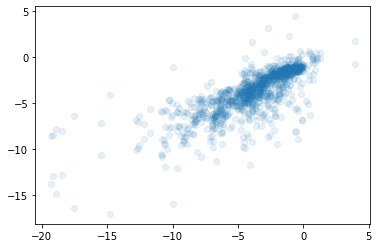

In [17]:
plt.scatter(true, preds, alpha=0.1)

In [20]:
np.corrcoef(true, preds)

array([[1.        , 0.77213511],
       [0.77213511, 1.        ]])

In [19]:
np.mean(np.square(true - preds))

3.897673584623165

In [5]:
random_state = 0
train_size = 0.8
training, validation = train_test_split(data, train_size=train_size,
                                    random_state=random_state)
dataloader = nci.get_data_loader(data, batch_size=1, shuffle=False)
validloader = nci.get_data_loader(validation, batch_size=1, shuffle=False)

In [7]:
identifiers_gen, true_gen, predictions_gen = nci.get_predictions(dataloader, model, AEVC, device)

0.9208302210497988


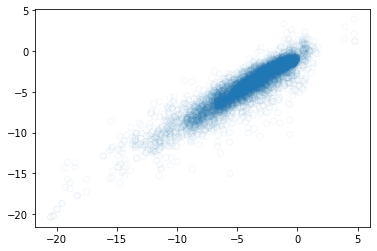

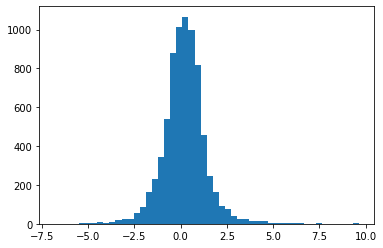

In [210]:
nci.analyze_pairs(true_gen, predictions_gen, alpha=0.05)

In [16]:
pair1_gen = predictions_gen[::2]
pair2_gen = predictions_gen[1::2]

0.8648473235207745


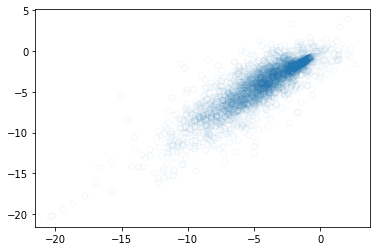

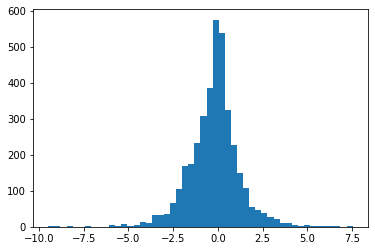

In [24]:
nci.analyze_pairs(pair1_gen, pair2_gen, alpha=0.05)

In [26]:
identifiers_valid, true_valid, predictions_valid = nci.get_predictions(validloader, model, AEVC, device)

In [27]:
selected_preds = []
sorted_ids = sorted(identifiers_valid)
sorted_preds = [x for _, x in sorted(zip(identifiers_valid, predictions_valid), key=lambda pair: pair[0])]
for i in range(len(sorted_ids) - 1):
    if sorted_ids[i] == sorted_ids[i+1]:
        selected_preds.append(sorted_preds[i])
        selected_preds.append(sorted_preds[i+1])

In [209]:
data[0]

{'species': tensor([1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3]),
 'coordinates': tensor([[-1.6767, -0.1555,  0.0000],
         [-0.9935, -1.1558,  0.0000],
         [-1.1739,  1.0802,  0.0000],
         [-0.1859,  1.0356,  0.0000],
         [-3.1810, -0.1561,  0.0000],
         [-3.5503, -1.1755,  0.0000],
         [-3.5490,  0.3752, -0.8767],
         [-3.5490,  0.3752,  0.8767],
         [ 3.3838, -1.0550,  0.8742],
         [ 3.3838, -1.0550, -0.8742],
         [ 3.7187,  0.4683,  0.0000],
         [ 0.9883, -1.0291,  0.0000],
         [ 3.1362, -0.4486,  0.0000],
         [ 1.6711, -0.1654,  0.0000],
         [ 1.2065,  0.9555,  0.0000]]),
 'index_diff': tensor([8]),
 'energies': array([-4.591]),
 'id': 0}

In [208]:
identifiers_valid

array([ 781, 2666, 3712, ..., 1047,   10, 2277])

In [28]:
pair1_valid = np.array(selected_preds[::2])
pair2_valid = np.array(selected_preds[1::2])

0.8252546009665132


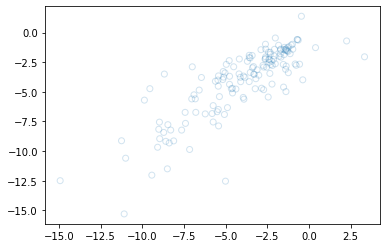

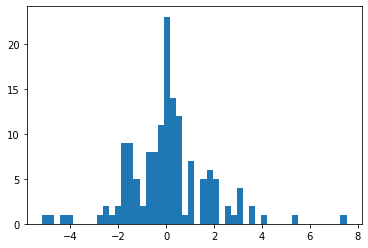

In [29]:
nci.analyze_pairs(pair1_valid, pair2_valid)

In [31]:
f = np.array([0.8, 0.85, 0.90, 0.95, 1.0, 1.05, 1.1, 1.25, 1.5, 2.0])
errors = np.square(predictions_gen - true_gen)
error_stack = np.hstack((errors[::2].reshape(-1, 10), errors[1::2].reshape(-1, 10))).reshape(-1, 2, 10)
f_stack = np.tile(f, 375 * 2).reshape(-1, 2, 10)
error_mean = error_stack.mean(axis=1).mean(axis=0)
error_sd = error_stack.mean(axis=1).std(axis=0)
error_q = np.quantile(error_stack.mean(axis=1), (0.05, 0.95), axis=0)

In [207]:
error_stack.shape

(375, 2, 10)

In [179]:
sum(np.sort(errors) < 0.05)

1413

In [178]:
errors.shape

(7500,)

* Randomization at molecule-pair level.
* Randomization at interaction type (including the sub-categories of ionic, hydrogen, etc.)

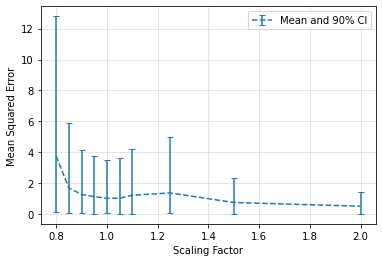

In [170]:
plt.errorbar(f, error_mean, ls='dashed', yerr=np.abs(error_q - error_mean),
            capsize=3, label="Mean and 90% CI")
plt.ylabel("Mean Squared Error")
plt.grid(alpha=0.4)
plt.xlabel("Scaling Factor")
plt.legend()
plt.show()

In [171]:
error_q

array([[1.17229605e-01, 6.15011431e-02, 4.84090066e-02, 3.36114880e-02,
        3.76398357e-02, 2.14629691e-02, 3.67809145e-02, 3.89766672e-02,
        2.00828617e-02, 1.06720935e-02],
       [1.28029799e+01, 5.91004359e+00, 4.15534441e+00, 3.78695496e+00,
        3.48409404e+00, 3.61103096e+00, 4.20522609e+00, 4.99724252e+00,
        2.33918127e+00, 1.43715750e+00]])

In [188]:
data[0]

{'species': tensor([1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3]),
 'coordinates': tensor([[-1.6767, -0.1555,  0.0000],
         [-0.9935, -1.1558,  0.0000],
         [-1.1739,  1.0802,  0.0000],
         [-0.1859,  1.0356,  0.0000],
         [-3.1810, -0.1561,  0.0000],
         [-3.5503, -1.1755,  0.0000],
         [-3.5490,  0.3752, -0.8767],
         [-3.5490,  0.3752,  0.8767],
         [ 3.3838, -1.0550,  0.8742],
         [ 3.3838, -1.0550, -0.8742],
         [ 3.7187,  0.4683,  0.0000],
         [ 0.9883, -1.0291,  0.0000],
         [ 3.1362, -0.4486,  0.0000],
         [ 1.6711, -0.1654,  0.0000],
         [ 1.2065,  0.9555,  0.0000]]),
 'index_diff': tensor([8]),
 'energies': array([-4.591]),
 'id': 0}

In [194]:
data[18]

{'species': tensor([1, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3]),
 'coordinates': tensor([[-1.6767, -0.1555,  0.0000],
         [-0.9935, -1.1558,  0.0000],
         [-1.1739,  1.0802,  0.0000],
         [-0.1859,  1.0356,  0.0000],
         [-3.1810, -0.1561,  0.0000],
         [-3.5503, -1.1755,  0.0000],
         [-3.5490,  0.3752, -0.8767],
         [-3.5490,  0.3752,  0.8767],
         [ 5.4724, -1.1752,  0.8742],
         [ 5.4724, -1.1752, -0.8742],
         [ 5.8073,  0.3481,  0.0000],
         [ 3.0770, -1.1493,  0.0000],
         [ 5.2248, -0.5688,  0.0000],
         [ 3.7597, -0.2856,  0.0000],
         [ 3.2951,  0.8353,  0.0000]]),
 'index_diff': tensor([8]),
 'energies': array([-2.157]),
 'id': 9}

In [202]:
idx = 18
s = data[idx]['species']
C = data[idx]['coordinates']
i = data[idx]['index_diff']
from scipy.spatial import distance
PC = distance.cdist(C[:int(i)], C[int(i):])

In [205]:
PC

array([[7.2741652 , 7.2741652 , 7.50096793, 4.85642259, 6.91390802,
        5.43799967, 5.06958091],
       [6.52477732, 6.52477732, 6.96516512, 4.0704922 , 6.24602009,
        4.8322643 , 4.72829642],
       [7.07281154, 7.07281154, 7.01954802, 4.80007002, 6.60783188,
        5.11923425, 4.47574859],
       [6.13745136, 6.13745136, 6.03256168, 3.92683446, 5.64361256,
        4.16098695, 3.48679481],
       [8.75691138, 8.75691138, 9.00243344, 6.33625726, 8.41593868,
        6.94191783, 6.55151353],
       [9.06490287, 9.06490287, 9.48083301, 6.62727097, 8.79605956,
        7.36397349, 7.13460006],
       [9.31960893, 9.15364922, 9.39736341, 6.85537278, 8.8679283 ,
        7.39074227, 6.91535745],
       [9.15364922, 9.31960893, 9.39736341, 6.85537278, 8.8679283 ,
        7.39074227, 6.91535745]])

In [ ]:

s[:int(i)]


from itertools import product
Ps = torch.Tensor(np.array(list(product(s[:int(i)], s[int(i):])))).reshape(8, 7, 2)
Ps.shape
PC
Ps
PC.shape
P
C[int(i):].shape
C[:int(i)], C[int(i):]